In [9]:

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('all_sampled_twitter.csv')

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)



In [10]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [11]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

model_checkpoint = './lora-sentiment-gpt2-2'
tokenizer = GPT2Tokenizer.from_pretrained(model_checkpoint)
tokenizer.pad_token = tokenizer.eos_token


In [12]:
def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    tokenized["labels"] = examples["label"]  # Add labels to the tokenized dataset
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/5246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

In [13]:
import torch

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model = GPT2ForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): lora.Linear(
            (base_layer): Conv1D(nf=2304, nx=768)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (c_proj): lora.Linear(
            (base_layer): Conv1D(nf=768, nx=

In [14]:
from peft import get_peft_model, LoraConfig
lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, lora_config)

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch (to match evaluation strategy)
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # Adjust batch size if necessary
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_58100/1172398762.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/55 [00:00<?, ?it/s]

Tweet Accuracy: 0.4088050314465409
Tweet Precision: 0.2557241486913446
Tweet Recall: 0.34553672316384176
Tweet F1 Score: 0.23300789199152325
Tweet Accuracy: 0.4088050314465409


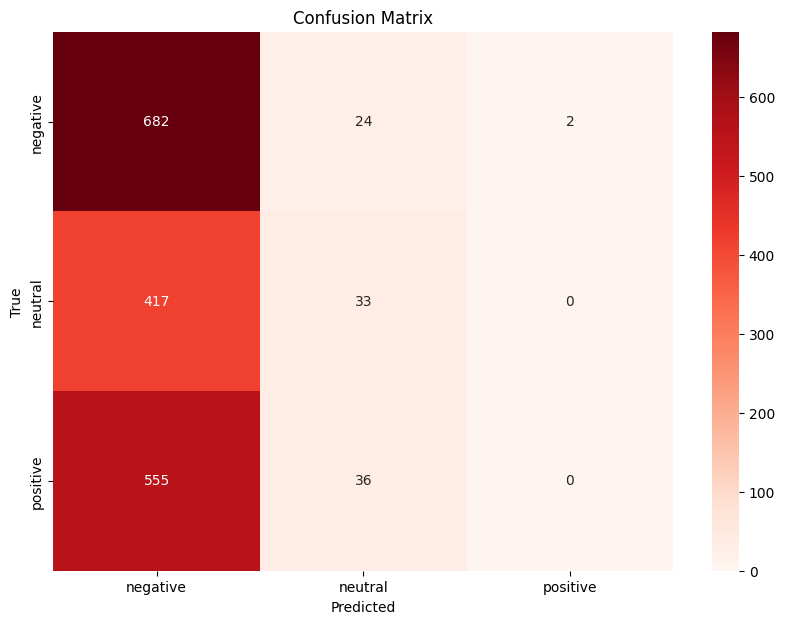

In [16]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
trainer.train()

  0%|          | 0/984 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.842505931854248, 'eval_runtime': 21.5312, 'eval_samples_per_second': 81.231, 'eval_steps_per_second': 2.554, 'epoch': 1.0}
{'loss': 1.7892, 'grad_norm': 120.40070343017578, 'learning_rate': 5e-05, 'epoch': 1.52}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.6913444995880127, 'eval_runtime': 21.157, 'eval_samples_per_second': 82.668, 'eval_steps_per_second': 2.6, 'epoch': 2.0}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.6502594351768494, 'eval_runtime': 20.8934, 'eval_samples_per_second': 83.711, 'eval_steps_per_second': 2.632, 'epoch': 3.0}
{'train_runtime': 571.255, 'train_samples_per_second': 27.55, 'train_steps_per_second': 1.723, 'train_loss': 1.5954721962533347, 'epoch': 3.0}


TrainOutput(global_step=984, training_loss=1.5954721962533347, metrics={'train_runtime': 571.255, 'train_samples_per_second': 27.55, 'train_steps_per_second': 1.723, 'total_flos': 1037911674322944.0, 'train_loss': 1.5954721962533347, 'epoch': 3.0})

In [20]:

trainer.evaluate()

  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.6502594351768494,
 'eval_runtime': 20.8564,
 'eval_samples_per_second': 83.859,
 'eval_steps_per_second': 2.637,
 'epoch': 3.0}

In [21]:

model.save_pretrained('./lora_finetuned_gpt2_sentiment_neologism')
tokenizer.save_pretrained('./lora_finetuned_gpt2_sentiment_neologism')

('./lora_finetuned_gpt2_sentiment_neologism/tokenizer_config.json',
 './lora_finetuned_gpt2_sentiment_neologism/special_tokens_map.json',
 './lora_finetuned_gpt2_sentiment_neologism/vocab.json',
 './lora_finetuned_gpt2_sentiment_neologism/merges.txt',
 './lora_finetuned_gpt2_sentiment_neologism/added_tokens.json')

  0%|          | 0/55 [00:00<?, ?it/s]

Tweet Accuracy: 0.6998284734133791
Tweet Precision: 0.6729532957798309
Tweet Recall: 0.6588839179022435
Tweet F1 Score: 0.6491093847412225
Tweet Accuracy: 0.6998284734133791


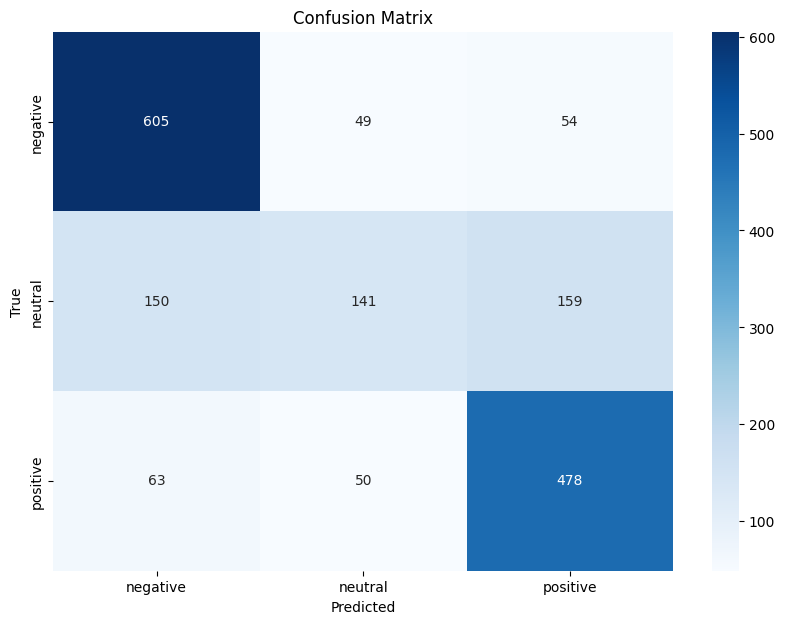

In [22]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
model.push_to_hub('srinathsk18/lora-finetuned-gpt-2-sentiment-analysis-neologism')
tokenizer.push_to_hub('srinathsk18/lora-finetuned-gpt-2-sentiment-analysis-neologism')

adapter_model.safetensors:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/srinathsk18/lora-finetuned-gpt-2-sentiment-analysis-neologism/commit/ec216e608df467555341a2f000a3a95df2bd2aac', commit_message='Upload tokenizer', commit_description='', oid='ec216e608df467555341a2f000a3a95df2bd2aac', pr_url=None, repo_url=RepoUrl('https://huggingface.co/srinathsk18/lora-finetuned-gpt-2-sentiment-analysis-neologism', endpoint='https://huggingface.co', repo_type='model', repo_id='srinathsk18/lora-finetuned-gpt-2-sentiment-analysis-neologism'), pr_revision=None, pr_num=None)

In [23]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

reddit_df = pd.read_csv('the-reddit-dataset-dataset-comments.csv')
reddit_df = reddit_df.dropna(subset=['body', 'sentiment'])
reddit_df['body'] = reddit_df['body'].astype(str)
reddit_df['sentiment'] = reddit_df['sentiment'].astype(float)
def assign_label(score):
    if score < -0.5:
        return 0  # Negative
    elif -0.5 <= score <= 0.5:
        return 1  # Neutral
    else:
        return 2  # Positive

reddit_df['text'] = reddit_df['body']
reddit_df['label'] = reddit_df['sentiment'].apply(assign_label)
reddit_df = reddit_df[['text', 'label']]
reddit_data = Dataset.from_pandas(reddit_df)


reddit_dataset = DatasetDict({
    'test': reddit_data
})


Map:   0%|          | 0/47370 [00:00<?, ? examples/s]

  0%|          | 0/1481 [00:00<?, ?it/s]

Reddit Accuracy: 0.36599113362887903
Reddit Precision: 0.4278849523375306
Reddit Recall: 0.534447281948402
Reddit F1 Score: 0.32758019491195317
Reddit Accuracy: 0.36599113362887903


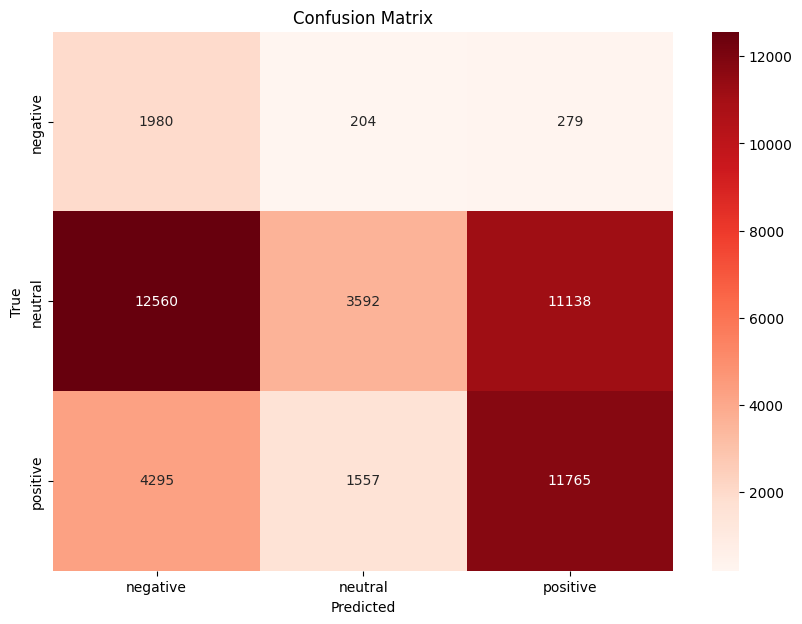

In [24]:
reddit_tokenized_datasets = reddit_dataset.map(preprocess_function, batched=True)
predictions = trainer.predict(reddit_tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(reddit_tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(reddit_tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Reddit Accuracy: {accuracy}')
print(f'Reddit Precision: {precision}')
print(f'Reddit Recall: {recall}')
print(f'Reddit F1 Score: {f1_score_}')
print(f'Reddit Accuracy: {accuracy}')

conf_matrix = confusion_matrix(reddit_tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('all_sampled_twitter.csv')

# Create a DatasetDict
dataset = DatasetDict({
    'test': Dataset.from_pandas(df)
})
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/8744 [00:00<?, ? examples/s]

  0%|          | 0/274 [00:00<?, ?it/s]

Tweet Accuracy: 0.7232387923147301
Tweet Precision: 0.696272932920647
Tweet Recall: 0.6790462145501953
Tweet F1 Score: 0.6743034775194906
Tweet Accuracy: 0.7232387923147301


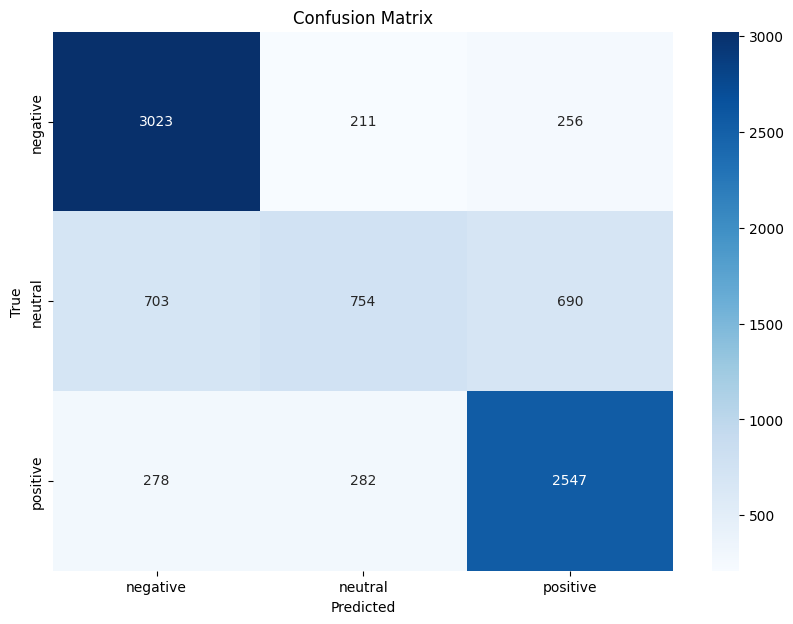

In [27]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
df = pd.DataFrame(predicted_labels.tolist(), columns=['gpt2'])
df.to_csv('gpt2twitter.csv', index=False)